In [43]:
import re
import matplotlib.pyplot as plt
import numpy as np


def prepare_boxplot_data(filename, unable_to_reach_first_line = False):
    iperfString = read_file(filename)
    client_data = []
    server_data = []
    first_run_client = True

    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()

    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")

        for index, s_c_entry in enumerate(server_client_list):
            line_list = s_c_entry.split("\n")
            if(unable_to_reach_first_line): # If the first line of the file is that we're unable to reach the destination, then we remove that from the string
                line_list.pop(0)
                unable_to_reach_first_line = False
            
            if(index % 2 == 0):
                if(first_run_client):
                    del line_list[0:3]
                    first_run_client = False
                else:
                    del line_list[0:4]                
                del line_list[-6:-1]
                line_list.pop()
                for line in line_list:
                    bitrate = find_between(line, "Bytes", "bits/sec").strip()
                    append_to_list(bitrate[:-1], client_data, bitrate[-1]) 
            else:
                del line_list[0:7]
                del line_list[-6:-1]
                line_list.pop()
                for line in line_list:
                    bitrate = find_between(line, "Bytes", "bits/sec").strip()
                    append_to_list(bitrate[:-1], server_data, bitrate[-1])

    return client_data, server_data


def scatter_plot_iperf_bitrate(path, y_label, x_label, x_axis_values, title, limits=[]):
    distance_iperf_files = path
    iperf_sender_results_list = []
    iperf_receiver_results_list = []

    for file in distance_iperf_files:
        iperfContent = read_file(file)
        iperf_output_list = split_iperf(iperfContent)
        iperf_list = extract_iperf(iperf_output_list)
        iperf_sender_list, iperf_receiver_list = [], []
        for index, entry in enumerate(iperf_list):
            if(index % 2 == 0):
                iperf_sender_list.append(entry)
            else:
                iperf_receiver_list.append(entry)

        iperf_sender_bitrate = [column[2] for column in iperf_sender_list]
        iperf_receiver_bitrate = [column[2] for column in iperf_receiver_list]
        iperf_sender_results_list.append(iperf_sender_bitrate)
        iperf_receiver_results_list.append(iperf_receiver_bitrate)

    iperf_sender_results_list[6].append(0.0)
    x_axis = x_axis_values

    y_axis = []
    for entry in iperf_sender_results_list:
        y_axis = np.concatenate((y_axis, entry))

            
    for x_value, y_value in zip(x_axis, y_axis):
        plt.scatter(x=x_value, y=y_value, marker='o', color='blue')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if(limits != []):
        plt.ylim(limits[1])
        plt.xlim(limits[0])
    plt.title(title)

# Reads and closes file before returning the content as a string
def read_file(fileName):
    file = open(fileName)
    fileContent = file.read()
    file.close()
    return fileContent

# Separates the inputted content into 4 lists of metrics (4 since we know that these metrics are always outputted)
def separate_metrics(fileString, ping_data = [], rss_data = [], route_data = [], link_data = []):
    fileString = remove_separations(fileString)
    # Split into lists of data
    ping_data = [] 
    rss_data = [] 
    route_data = [] 
    link_data = []
    for index, content in enumerate(fileString):
        if(index % 4 == 0):
            ping_data.append(content) 
        elif(index % 4 == 1):
            rss_data.append(content)
        elif(index % 4 == 2):
            route_data.append(content)
        elif(index % 4 == 3):
            link_data.append(content)
    #print("Length of ping_data - Sep Met: " + str(len(ping_data)))
    #print("Length of rss_data - Sep Met: " + str(len(rss_data)))
    #print("Length of route_data - Sep Met " + str(len(route_data)))
    #print("Length of link_data - Sep Met " + str(len(link_data)))
    return ping_data, rss_data, route_data, link_data

# Removes the redundant separations that are purely for visual assistance
def remove_separations(fileString):
    fileString = remove_occurrences(fileString, "----------------------------------------------------------------")
    fileString = remove_occurrences(fileString, "____________________________START_______________________________")
    fileString = remove_occurrences(fileString, "___________________________END__________________________________")
    fileString = remove_occurrences(fileString, "")
    return fileString

# Removes all occurences of a given item in a string
def remove_occurrences(fileString, item):
    res = [i for i in fileString if i != item]
    return res

# Extract packet loss, average rtt and the standard deviation of the rtt from the list of ping data
def read_ping_data(ping_data, packet_loss_list = [], avg_rtt_list = [], std_deviation_rtt = []):
    packet_loss_list = []
    avg_rtt_list = []
    std_deviation_rtt = []
    
    for entry in ping_data:
        ping_information = entry.split("---")[2]
        split_information = ping_information.split(",")
        packet_loss_list.append(split_information[2].split("%")[0])
        try: 
            avg_rtt_list.append(split_information[3].split("/")[4])
            std_deviation_rtt.append(split_information[3].split("/")[6][:-3])
        except:
            avg_rtt_list.append(np.nan)
            std_deviation_rtt.append(np.nan)
    return packet_loss_list, avg_rtt_list, std_deviation_rtt

# Extract RSS and average RSS from the list of RSS data
def read_rss_data(rss_data, rss_list = [], rss_avg_list = []):
    for entry in rss_data:
        rss_list.append(find_between(entry, "signal: ", "["))
        rss_avg_list.append(find_between(entry, "signal avg: ", "["))

    return rss_list, rss_avg_list

# Finds and returns the string between two given sequences of strings
def find_between(s, first, last, minusIndex = 0):
    start = s.index(first)+len(first)
    end = s.index(last, start)+minusIndex
    return s[start:end]

# Turns a list of strings into a list of floats
def list_string_to_float(stringList):
    floatList = [float(x) for x in stringList]
    return floatList

# Turns a list of strings into a list of floats
def list_string_to_int(stringList):
    intList = [int(x) for x in stringList]
    return intList

# Returns the average of a list
def list_average(list):
    return (sum(list) / len(list))


def split_iperf(iperfString):
    iperf_output_list = []
    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()
    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")
        server_client_edited_list = []
        str_to_find = "- - - - - - - - - - - - - - - - - - - - - - - - -"
        for s_c_entry in server_client_list:
            s_c_entry = s_c_entry[s_c_entry.find(str_to_find)+len(str_to_find)+1:]
            server_client_edited_list.append(s_c_entry)
        iperf_output_list.append(server_client_edited_list)

    return iperf_output_list

def append_to_list(value, list, unit):
    if(unit == 'M' or unit == 'm'):
        list.append(float(value)*1000*1000)
    elif(unit == 'K' or unit == 'k'):
        list.append(float(value)*1000)
    else:
        list.append(float(value))
    return
    
# Extracts iperf into a list of lists in the following format:
# Index 0 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# Index 1 (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
# Index 2 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# ...
# Index n (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
def extract_iperf(iperf_list):
    s_c_entry_list = []
    for s_c_entry in iperf_list:
        entry_list = []
        for entry in s_c_entry:
            entry_list = []
            time_taken = find_between(entry, "-", "sec").strip()
            entry_list.append(time_taken)
            
            bits_transferred = find_between(entry, "sec", "Bytes").strip()
            append_to_list(bits_transferred[:-1], entry_list, bits_transferred[-1])

            try:
                try:
                    transfer_rate = find_between(entry, "MBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
                except:
                    transfer_rate = find_between(entry, "KBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            except:
                transfer_rate = find_between(entry, " Bytes", "bits/sec").strip()
                append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            if "Retr" in entry:
                retry_number = find_between(entry, "/sec", "sender").strip()
                entry_list.append(retry_number)
            s_c_entry_list.append(entry_list)
    return s_c_entry_list



def read_station_dump(rss_data):
    mac_list = []
    signal_list = []
    rss_list = []
    rss_avg_list = []
    rss_list_sorted = []
    rss_dict = {}
    rss_avg_list_sorted = []

    for entry in rss_data:
       mac_list.append(re.findall(r'(?:[0-9a-fA-F]:?){12}',entry, re.ASCII))
       signal_list.append(re.findall(r'\[.*?\]',entry))
      
    for entry in signal_list:
        temp_list = []
        temp_list = [s.strip("[]") for s in entry]
        temp_list = list(map(int, temp_list))
        rss_list.append(temp_list)
       
    for i, entry in enumerate(rss_list):
        temp_list = []
        for j, content in enumerate(entry):
            if(j % 2 == 1):
                temp_list.append(content)
                rss_list[i][j] = 0
        rss_avg_list.append(temp_list)
        entry = [i for i in entry if i != 0]
        rss_list[i] = entry

    rss_dict = dict.fromkeys(mac_list[0])

    if(len(rss_dict.keys()) == 2):
        for i in range(2):
            rss_list_sorted.append([entry[i] for entry in rss_list])
            rss_avg_list_sorted.append([entry[i] for entry in rss_avg_list])
    elif(len(rss_dict.keys()) == 3):
         for i in range(3):
            rss_list_sorted.append([entry[i] for entry in rss_list])
            rss_avg_list_sorted.append([entry[i] for entry in rss_avg_list])
    else:
            rss_list_sorted.append([entry[0] for entry in rss_list])
            rss_avg_list_sorted.append([entry[0] for entry in rss_avg_list])


    for i, mac_addr in enumerate(mac_list[0]):
        calculated_raw_avg = sum(rss_list_sorted[i]) / len(rss_list_sorted[i])
        calculated_avg_of_avg = sum(rss_avg_list_sorted[i]) / len(rss_avg_list_sorted[i])
        rss_dict[mac_addr] = (calculated_raw_avg, calculated_avg_of_avg)

    
    #Hvis dbm signalet ikke findes for en mac adresse sættes dette til NaN    
      
    return rss_dict

In [10]:
#def plot_rss(path, data_value, y_label, x_label, x_axis_values, title):
def plot_rss(path):
    unsorted_data = []
    extracted_rss = []
    extracted_raw_avg = {}
    extracted_avg_of_avg = {}
    for file in path:
        separated_metrics = []
        file_content = read_file(file)
        split_content = file_content.split("\n")
        separated_metrics = separate_metrics(split_content)[1]
        unsorted_data.append(separated_metrics)
    
    for entry in unsorted_data:
        extracted_rss.append(read_station_dump(entry))
    
    extracted_raw_avg = {}
    extracted_avg_of_avg = {}
    for key in extracted_rss[0].keys():
        extracted_raw_avg[key] = []
        extracted_avg_of_avg[key] = []
        
    for entry in extracted_rss:
        for key, value in entry.items():
            extracted_raw_avg[key].append(value[0])
            extracted_avg_of_avg[key].append(value[1])
            
    print(extracted_raw_avg)
    
    x_axis = [10,20,30,40,50,60,70,80,90,100]
    for key, value in extracted_raw_avg.items():
        plt.plot(x_axis, value, label=key)
            
    
    plt.legend()
    plt.ylabel("RSS [dB]")
    plt.xlabel("Distance [m]")
    plt.title("Signal Strength - Single Hop")
    
    
    #print(extracted_avg_of_avg)
    #print(extracted_raw_avg)
    #x_axis = list(range(1,len(iperf_sender_bytes)+1)) 
    #print(extracted_rss)

{'e4:95:6e:4b:b3:dc': [-75.93333333333334, -68.86666666666666, -72.06666666666666, -71.8, -67.8, -70.6, -71.13333333333334, -71.46666666666667, -71.53333333333333, -70.06666666666666], 'e4:95:6e:4e:3d:a4': [-69.4, -73.26666666666667, -76.06666666666666, -75.86666666666666, -77.06666666666666, -78.26666666666667, -80.26666666666667, -79.8, -83.4, -83.93333333333334]}


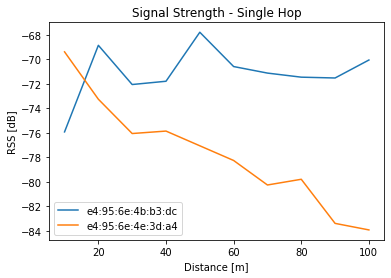

In [41]:
distance_file_result = "../Distance/Dongle/multi-hop_interference/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
plot_rss(distance_result_files)

In [48]:
def scatter_plot_packet_loss(path, data_value, y_label, x_label, x_axis_values, title):
    file_path = path
    data = []
    raw_data = []
    x_axis = x_axis_values
    y_axis = []
    converted_data = []

    for file in file_path:
        file_content = read_file(file)
        split_content = file_content.split("\n")
        raw_data.append(separate_metrics(split_content)[0])

    for entry in raw_data:
        if(data_value == 'packet_loss'):
            data.append(read_ping_data(entry)[0])
        elif(data_value == 'avg_rtt'):
            data.append(read_ping_data(entry)[1])
        elif(data_value == 'std_deviation'):
            data.append(read_ping_data(entry)[2])

    converted_data = [[int(x) for x in lst] for lst in data]
    
    for entry in converted_data:
        y_axis = np.concatenate((y_axis, entry))
    for x_value, y_value in zip(x_axis, y_axis):
        plt.scatter(x=x_value, y=y_value, marker='o', color='blue')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)

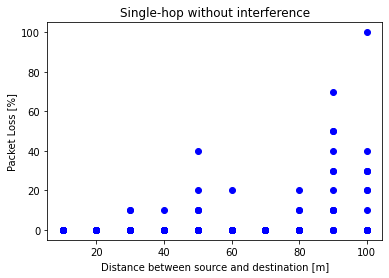

In [49]:
distance_file_result = "../Distance/Dongle/multi-hop/results_"
distance_result_files = [distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
                        
y_label = "Packet Loss [%]"
x_label = "Distance between source and destination [m]"
title = "Single-hop without interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

scatter_plot_packet_loss(distance_result_files,'packet_loss',y_label,x_label,x_axis,title)

In [ ]:
content = read_file("../Distance/Dongle/multi-hop/results_100m.txt")
split_content = content.split("\n")
ping_data, rss_data, route_data, link_data = separate_metrics(split_content)
#packet_loss_list, avg_rtt_list, std_deviation_rtt = read_ping_data(ping_data)
#rss_list, rss_avg_list = read_rss_data(rss_data)
rss_values = read_station_dump(rss_data)
#iperfContent = read_file("../Dongle/iperf_results.txt")
#iperf_output_list = split_iperf(iperfContent)
#iperf_list = extract_iperf(iperf_output_list)
#hello = 1
#print(mac_list)
#print(rss_list)
#print(rss_avg_list)
# TODO: Still missing extraction of LINK and ROUTE metrics 
# I am not sure what is important in these measurements, so figure this out. In route the routing metric is probably important/interesting to look at
#
# Answer: Routing protocol metric might be interesting to look at. The stale metric from Link. And the p metric from route.


# TODO: How should we do the plotting of different experiments within one experiment? 
# Should we just average the measurements across the list of data measurements from each experiment and then plot these averages against each other?
#
# Answer: Attempt to use the full range of measurements across one experiment and then color code according to experiment.

In [ ]:
import matplotlib.pyplot as plt

# ######### Prepare lists by turning them into floats/ints instead of strings######
# # Int
# rss_list = list_string_to_int(rss_list)
# rss_avg_list = list_string_to_int(rss_avg_list)
iperf_sender_list = [column[1] for column in iperf_list]
iperf_receiver_list = [column[2] for column in iperf_list]
iperf_sender_bytes = list_string_to_float(iperf_sender_list)
iperf_receiver_bytes = list_string_to_float(iperf_receiver_list)

# # Float
# avg_rtt_list = list_string_to_float(avg_rtt_list)
# std_deviation_rtt = list_string_to_float(std_deviation_rtt)
# packet_loss_list = list_string_to_float(packet_loss_list)
# #################################################################################

# # Example of plotting
# x_axis = list(range(1, len(rss_avg_list)+1))
# fig_avg_rss, axis_avg_rss = plt.subplots()
# axis_avg_rss.plot(x_axis, rss_avg_list)
# axis_avg_rss.set_title("Average of RSS")
# axis_avg_rss.set_xlabel("Sample number")
# axis_avg_rss.set_ylabel("Average RSS value")
x_axis = list(range(1,len(iperf_sender_bytes)+1))
fig_iperf, axis_iperf = plt.subplots()
axis_iperf.plot(x_axis, iperf_sender_bytes)
axis_iperf.plot(x_axis, iperf_receiver_bytes)

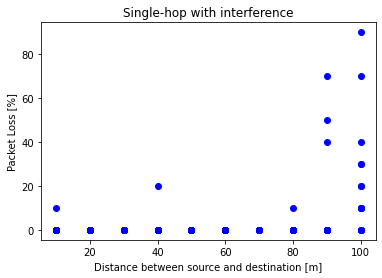

In [50]:
distance_file_result = "../Distance/Dongle/Single-hop_interference/results_"
distance_result_files = [distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
#print(distance_result_files)
y_label = "Packet Loss [%]"
x_label = "Distance between source and destination [m]"
title = "Single-hop with interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

scatter_plot_packet_loss(distance_result_files,'packet_loss',y_label,x_label,x_axis,title)

In [ ]:
############# DISTANCE EXPERIMENT - Single-hop #####################
distance_file_iperf = "../Distance/Dongle/Single-hop/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]
print(distance_iperf_files)
y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [m]"
title = "Single-hop without interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

limits = [(5, 105), (0, 9000000)]


scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
############# DISTANCE EXPERIMENT Single-hop interference #####################
distance_interference_file_iperf = "../Distance/Dongle/Single-hop_interference/iperf_results_"
distance_interference_iperf_files = [distance_interference_file_iperf + "10m.txt",
                        distance_interference_file_iperf + "20m.txt",
                        distance_interference_file_iperf + "30m.txt",
                        distance_interference_file_iperf + "40m.txt",
                        distance_interference_file_iperf + "50m.txt",
                        distance_interference_file_iperf + "60m.txt",
                        distance_interference_file_iperf + "70m.txt",
                        distance_interference_file_iperf + "80m.txt",
                        distance_interference_file_iperf + "90m.txt",
                        distance_interference_file_iperf + "100m.txt"
                        ]

y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [m]"
title = "Single-hop with interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

limits = [(5, 105), (0, 9000000)]


scatter_plot_iperf_bitrate(distance_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
filenames = ["../Distance/Dongle/Single-hop/iperf_results_10m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_20m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_30m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_40m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_50m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_60m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_70m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_80m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_90m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_100m.txt"]
filenames_interference = ["../Distance/Dongle/Single-hop_interference/iperf_results_10m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_20m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_30m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_40m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_50m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_60m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_70m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_80m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_90m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_100m.txt"]
boxplot_titles = ['10m', '20m', '30m', '40m', '50m', '60m', '70m', '80m', '90m', '100m']
            

for filename, filename_int, title in zip(filenames, filenames_interference, boxplot_titles):
    client_data, server_data = prepare_boxplot_data(filename)
    client_interference_data, server_interference_data = prepare_boxplot_data(filename_int)
    data_dict = {'Client': client_data, 'Client w. interference': client_interference_data,
                'Server': server_data, 'Server w. interference': server_interference_data}
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 9000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [Bytes/sec]')
    ax.set_title(title + ' between Source and Destination')

In [ ]:
######################################################################################################################
######################################################################################################################
########################## DISTANCE EXPERIMENT - Multi-hop ###########################################################
######################################################################################################################
######################################################################################################################

distance_file_iperf = "../Distance/Dongle/Multi-hop/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]
y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [m]"
title = "Multi-hop without interference"
x_axis = [  50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
            110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
            120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
            130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
            140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
limits = [(45, 145), (0, 7000000)]

scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
########################## DISTANCE EXPERIMENT - Multi-hop interference ###########################################################
distance_interference_file_iperf = "../Distance/Dongle/Multi-hop_interference/iperf_results_"
distance_interference_iperf_files = [distance_interference_file_iperf + "10m.txt",
                        distance_interference_file_iperf + "20m.txt",
                        distance_interference_file_iperf + "30m.txt",
                        distance_interference_file_iperf + "40m.txt",
                        distance_interference_file_iperf + "50m.txt",
                        distance_interference_file_iperf + "60m.txt",
                        distance_interference_file_iperf + "70m.txt",
                        distance_interference_file_iperf + "80m.txt"
                        ]
y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [m]"
title = "Multi-hop with interference"
x_axis = [  50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
            110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
            120, 120, 120, 120, 120, 120, 120, 120, 120, 120]

limits = [(45, 145), (0, 7000000)]


scatter_plot_iperf_bitrate(distance_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
filenames = ["../Distance/Dongle/Multi-hop/iperf_results_10m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_20m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_30m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_40m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_50m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_60m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_70m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_80m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_90m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_100m.txt"]
filenames_interference = ["../Distance/Dongle/Multi-hop_interference/iperf_results_10m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_20m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_30m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_40m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_50m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_60m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_70m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_80m.txt",
                        "DOES NOT EXIST",
                        "DOES NOT EXIST"] 
                        # 90m & 100m does not exist because it was not possible to create a connection during interference
boxplot_titles = ['50m', '60m', '70m', '80m', '90m', '100m', '110m', '120m', '130m', '140m']

for filename, filename_interference, title in zip(filenames, filenames_interference, boxplot_titles):
    if('40m' in filename):
        client_data, server_data = prepare_boxplot_data(filename, True)
    else:
        client_data, server_data = prepare_boxplot_data(filename)
    
    if('DOES NOT EXIST' not in filename_interference):
        client_interference_data, server_interference_data = prepare_boxplot_data(filename_interference)
        data_dict = {'Client': client_data, 'Client w. interference': client_interference_data,
                    'Server': server_data, 'Server w. interference': server_interference_data
                    }    
    else:
        data_dict = {'Client': client_data,
                    'Server': server_data,
                    }    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 8000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [Bytes/sec]')
    ax.set_title(title + ' distance between Source and Destination')